In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint
import matplotlib.pyplot as plt


In [2]:
# Cargar el dataset desde UCI Machine Learning Repository
vertebral_column = fetch_ucirepo(id=212)
X = vertebral_column.data.features
y = vertebral_column.data.targets

# Mostrar primeras filas del dataset
print(X.head(), y.head())


   pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
0         63.027817    22.552586              39.609117     40.475232   
1         39.056951    10.060991              25.015378     28.995960   
2         68.832021    22.218482              50.092194     46.613539   
3         69.297008    24.652878              44.311238     44.644130   
4         49.712859     9.652075              28.317406     40.060784   

   pelvic_radius  degree_spondylolisthesis  
0      98.672917                 -0.254400  
1     114.405425                  4.564259  
2     105.985135                 -3.530317  
3     101.868495                 11.211523  
4     108.168725                  7.918501       class
0  Hernia
1  Hernia
2  Hernia
3  Hernia
4  Hernia


In [3]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
# Buscar hiperparámetros con GridSearchCV
param_grid = {'max_depth': [None, 4, 6, 8, 10], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros (GridSearchCV):", grid_search.best_params_)


Mejores hiperparámetros (GridSearchCV): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [5]:
# Evaluar el modelo final
clf_final = grid_search.best_estimator_
y_pred_final = clf_final.predict(X_test_scaled)

# Imprimir métricas de rendimiento
print(f"Accuracy: {accuracy_score(y_test, y_pred_final)}")
print(classification_report(y_test, y_pred_final))


Accuracy: 0.7634408602150538
                   precision    recall  f1-score   support

           Hernia       0.53      0.44      0.48        18
           Normal       0.55      0.67      0.60        24
Spondylolisthesis       0.96      0.92      0.94        51

         accuracy                           0.76        93
        macro avg       0.68      0.68      0.68        93
     weighted avg       0.77      0.76      0.77        93



In [6]:
# Poda del árbol usando max_depth y min_samples_leaf
depth_scores = []
for depth in [4, 6, 8]:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    depth_scores.append(accuracy_score(y_test, y_pred))
    print(f"Accuracy (max_depth={depth}): {accuracy_score(y_test, y_pred)}")

min_samples_scores = []
for min_samples in [2, 4, 6]:
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples, random_state=42)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    min_samples_scores.append(accuracy_score(y_test, y_pred))
    print(f"Accuracy (min_samples_leaf={min_samples}): {accuracy_score(y_test, y_pred)}")


Accuracy (max_depth=4): 0.7634408602150538
Accuracy (max_depth=6): 0.7204301075268817
Accuracy (max_depth=8): 0.7849462365591398
Accuracy (min_samples_leaf=2): 0.7204301075268817
Accuracy (min_samples_leaf=4): 0.7741935483870968
Accuracy (min_samples_leaf=6): 0.7849462365591398


In [7]:
# Búsqueda de hiperparámetros con RandomizedSearchCV
param_dist = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 4, 6, 8], 'min_samples_split': randint(2, 6), 'min_samples_leaf': randint(1, 6)}
random_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy')
random_search.fit(X_train_scaled, y_train)

# Mostrar mejores hiperparámetros con RandomizedSearchCV
print("Mejores hiperparámetros (RandomizedSearchCV):", random_search.best_params_)
print("Mejor accuracy (RandomizedSearchCV):", random_search.best_score_)


Mejores hiperparámetros (RandomizedSearchCV): {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}
Mejor accuracy (RandomizedSearchCV): 0.7922832980972516


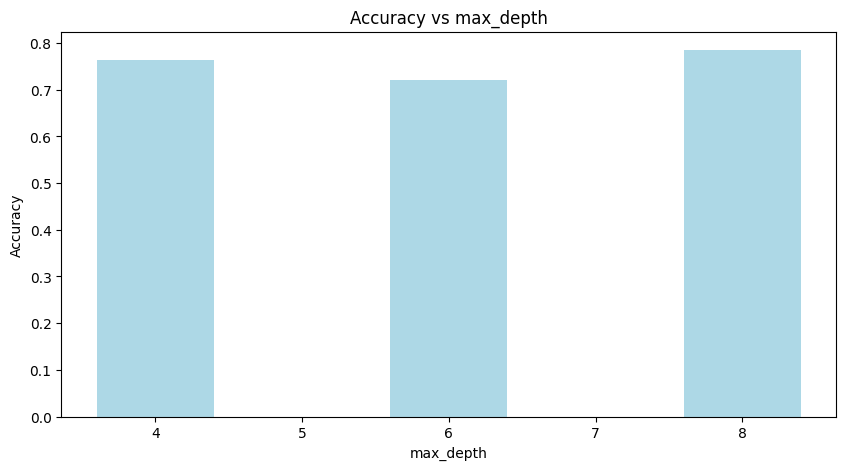

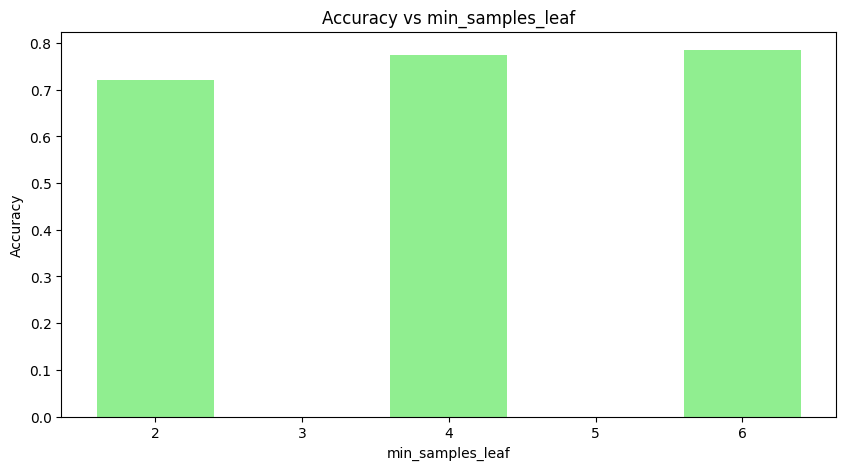

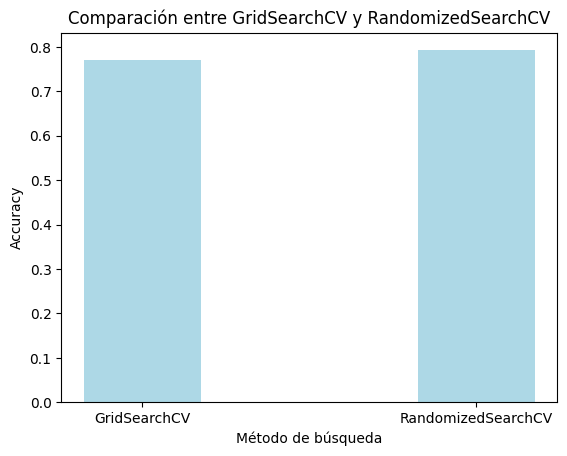

In [8]:
# Graficar resultados de poda por max_depth
plt.figure(figsize=(10, 5))
plt.bar([4, 6, 8], depth_scores, color='lightblue')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.show()

# Graficar resultados de poda por min_samples_leaf
plt.figure(figsize=(10, 5))
plt.bar([2, 4, 6], min_samples_scores, color='lightgreen')
plt.title("Accuracy vs min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.show()

# Comparar GridSearchCV y RandomizedSearchCV
labels = ['GridSearchCV', 'RandomizedSearchCV']
accuracy_scores = [grid_search.best_score_, random_search.best_score_]

fig, ax = plt.subplots()
ax.bar(range(len(labels)), accuracy_scores, width=0.35, color='lightblue')
ax.set_xlabel('Método de búsqueda')
ax.set_ylabel('Accuracy')
ax.set_title('Comparación entre GridSearchCV y RandomizedSearchCV')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
plt.show()
